In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ETH2019-2024.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.4 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 18s 299ms/step - loss: 0.0273
Epoch 2/100
16/16 [==============================] - 3s 210ms/step - loss: 0.0042
Epoch 3/100
16/16 [==============================] - 2s 151ms/step - loss: 0.0032
Epoch 4/100
16/16 [==============================] - 2s 140ms/step - loss: 0.0032
Epoch 5/100
16/16 [==============================] - 2s 140ms/step - loss: 0.0029
Epoch 6/100
16/16 [==============================] - 2s 141ms/step - loss: 0.0029
Epoch 7/100
16/16 [==============================] - 3s 183ms/step - loss: 0.0033
Epoch 8/100
16/16 [==============================] - 3s 177ms/step - loss: 0.0026
Epoch 9/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0025
Epoch 10/100
16/16 [==============================] - 2s 140ms/step - loss: 0.0026
Epoch 11/100
16/16 [==============================] - 2s 139ms/step - loss: 0.0026
Epoch 12/100
16/16 [==============================] - 2s 153ms/step - loss: 0.0022
Epoch 13/100

In [10]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

20/20 [==============================] - 1s 35ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 1702.6036833828623


RMSE đo lường độ lệch chuẩn của các dự đoán so với giá trị thực tế. RMSE càng nhỏ thì mô hình càng chính xác. Với RMSE = 1702.60, mô hình đã cải thiện đáng kể so với các giá trị trước đó, nhưng vẫn có mức sai số khá lớn. Điều này cho thấy mô hình dự đoán đã có sự cải thiện nhưng vẫn cần được tối ưu hóa thêm.

In [13]:
# Tính MAPE
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

Testing MAPE: 516187.7044466009


MAPE đo lường phần trăm sai số tuyệt đối giữa giá trị dự đoán và giá trị thực tế. MAPE càng nhỏ thì mô hình càng chính xác. Với MAPE = 516187.7%, giá trị này vẫn rất cao, mặc dù đã có sự cải thiện so với các kết quả trước đó.

In [14]:
# Tính MSE
test_mse = np.mean((y_pred - ytest) ** 2)
print('Testing MSE:', test_mse)

Testing MSE: 2898859.30266889


MSE đo lường sai số trung bình của mô hình bằng cách tính trung bình của các bình phương sai số. MSE càng nhỏ thì mô hình càng chính xác. Với MSE = 2898859.30, mô hình đã có sự cải thiện đáng kể, nhưng vẫn có mức sai số khá lớn.

In [15]:
# 13. Dự báo 30 ngày tiếp theo
from numpy import array

x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1



0 day input [0.41852423 0.41308425 0.4114833  0.41362696 0.39741659 0.41472088
 0.39355163 0.39363653 0.39406284 0.40468065 0.40660231 0.38848624
 0.41557526 0.41510422 0.41913304 0.41982664 0.41533296 0.40770371
 0.41236624 0.40823798 0.41305071 0.42040663 0.43711715 0.44307008
 0.45360381 0.4643719  0.4511462  0.47792886 0.47817396 0.47443969
 0.47684049 0.44963975 0.44484535 0.45731176 0.4692081  0.4485249
 0.4501391  0.44366341 0.4480859  0.43970537 0.4448184  0.4528225
 0.47132356 0.4676059  0.4583845  0.45984566 0.4511045  0.48242966
 0.47579902 0.46582865 0.46399407 0.46174069 0.47681183 0.47755809
 0.44670091 0.45909618 0.45901304 0.4532654  0.44927542 0.47270777
 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382 0.50231726
 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788 0.50175317
 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788  0.45870516
 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897 0.46649526
 0.46739144 0.4648391  0.46345822 0.46544542 0.48103

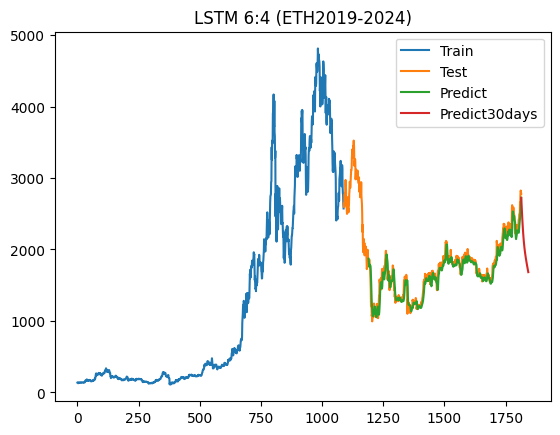

In [16]:
# 14.Vẽ hình
plt.title('LSTM 6:4 (ETH2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [17]:
from numpy import array

y_input = test_data[60:].reshape(1, -1)
y_input.shape

temp_input = list(y_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 60):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        y_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, y_input))
        y_input = y_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(y_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        y_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(y_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.41852423 0.41308425 0.4114833  0.41362696 0.39741659 0.41472088
 0.39355163 0.39363653 0.39406284 0.40468065 0.40660231 0.38848624
 0.41557526 0.41510422 0.41913304 0.41982664 0.41533296 0.40770371
 0.41236624 0.40823798 0.41305071 0.42040663 0.43711715 0.44307008
 0.45360381 0.4643719  0.4511462  0.47792886 0.47817396 0.47443969
 0.47684049 0.44963975 0.44484535 0.45731176 0.4692081  0.4485249
 0.4501391  0.44366341 0.4480859  0.43970537 0.4448184  0.4528225
 0.47132356 0.4676059  0.4583845  0.45984566 0.4511045  0.48242966
 0.47579902 0.46582865 0.46399407 0.46174069 0.47681183 0.47755809
 0.44670091 0.45909618 0.45901304 0.4532654  0.44927542 0.47270777
 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382 0.50231726
 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788 0.50175317
 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788  0.45870516
 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897 0.46649526
 0.46739144 0.4648391  0.46345822 0.46544542 0.48103

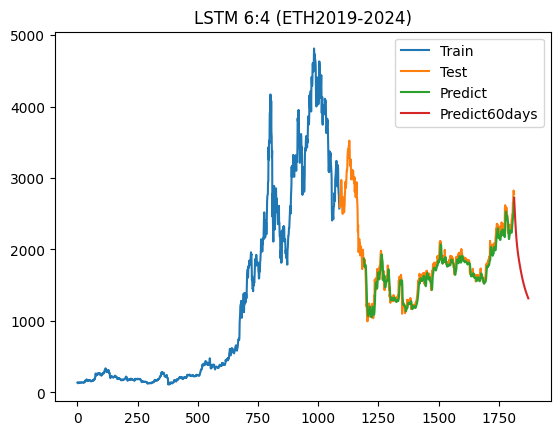

In [18]:
# 14.Vẽ hình
plt.title('LSTM 6:4 (ETH2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()

In [19]:
from numpy import array

z_input = test_data[60:].reshape(1, -1)
z_input.shape

temp_input = list(z_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        z_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, z_input))
        z_input = z_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model.predict(z_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        z_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(z_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.41852423 0.41308425 0.4114833  0.41362696 0.39741659 0.41472088
 0.39355163 0.39363653 0.39406284 0.40468065 0.40660231 0.38848624
 0.41557526 0.41510422 0.41913304 0.41982664 0.41533296 0.40770371
 0.41236624 0.40823798 0.41305071 0.42040663 0.43711715 0.44307008
 0.45360381 0.4643719  0.4511462  0.47792886 0.47817396 0.47443969
 0.47684049 0.44963975 0.44484535 0.45731176 0.4692081  0.4485249
 0.4501391  0.44366341 0.4480859  0.43970537 0.4448184  0.4528225
 0.47132356 0.4676059  0.4583845  0.45984566 0.4511045  0.48242966
 0.47579902 0.46582865 0.46399407 0.46174069 0.47681183 0.47755809
 0.44670091 0.45909618 0.45901304 0.4532654  0.44927542 0.47270777
 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382 0.50231726
 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788 0.50175317
 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788  0.45870516
 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897 0.46649526
 0.46739144 0.4648391  0.46345822 0.46544542 0.48103

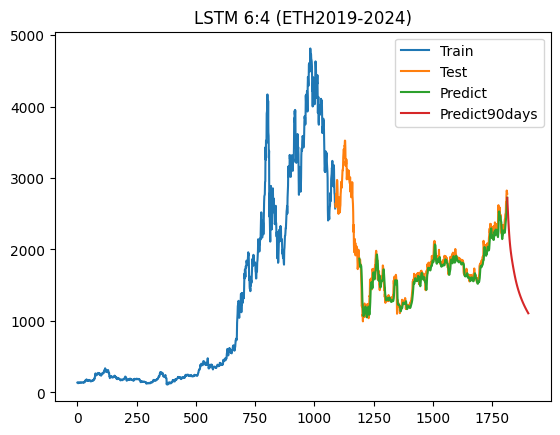

In [20]:
plt.title('LSTM 6:4 (ETH2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect90days_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect90days_data_index,scaler.inverse_transform(lst_output))  # Vẽ dự đoán cho 90 ngày
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()
